In [ ]:
#Import required libraries for data processing, model training, and evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Read the phishing dataset CSV file into a pandas DataFrame
data = pd.read_csv("dataset_phishing.csv")
data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


#**PRE PROCESSING**

In [ ]:
#-----Prepare Tabular & Text Data------

# Drop the raw URL and the label column to prepare tabular feature set for ML models
X_tabular = data.drop(columns=['url', 'status'])

# Ensure all columns are numeric
# Any non-numeric values are coerced to NaN and filled with 0
X_tabular = X_tabular.apply(pd.to_numeric, errors='coerce').fillna(0)


#Extract raw URL column for CNN
X_text = data['url'].astype(str) # Ensure all URLs are strings

#Create target labels by mapping legitimate to 0 and phishing to 1
y = data['status'].map({'legitimate': 0, 'phishing': 1})

#Split the data into 80:20 ratio
X_train_tab, X_test_tab, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_tabular, X_text, y, test_size=0.2, stratify=y, random_state=42
)

print(f"X_train_tab shape: {X_train_tab.shape}")
print(f"X_train_text shape: {X_train_text.shape}")
print(f"y_train shape: {y_train.shape}")


# --- Preprocessing Pipeline ---

#Tabular Data Pipeline for ML models
print("\nScaling tabular data...")

#Standardize tabular features (mean=0, std=1)
scaler = StandardScaler()
X_train_tab_scaled = scaler.fit_transform(X_train_tab)
X_test_tab_scaled = scaler.transform(X_test_tab)

#Text Data Pipeline for CNN
print("Tokenizing and padding text data...")

MAX_LENGTH = 200  # Max length for a URL
EMBEDDING_DIM = 64 # Size of the vector for each character

# Use character-level tokenization (each character is treated as a token)
tokenizer = Tokenizer(char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train_text)
vocab_size = len(tokenizer.word_index) + 1

# Convert URLs to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences to a fixed length for CNN input
X_train_url_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post')
X_test_url_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post')

print(f"Vocab size (characters): {vocab_size}")
print(f"Padded URL train shape: {X_train_url_padded.shape}")


X_train_tab shape: (9144, 87)
X_train_text shape: (9144,)
y_train shape: (9144,)

Scaling tabular data...
Tokenizing and padding text data...
Vocab size (characters): 75
Padded URL train shape: (9144, 200)


#**LOGISTIC REGRESSION**

Accuracy: 0.9361329833770778
Precision: 0.9392070484581497
Recall: 0.9326334208223972
F1: 0.935908691834943
ROC AUC: 0.9361329833770778


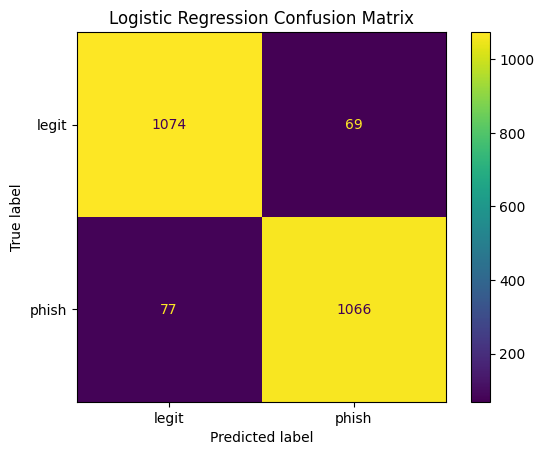

In [ ]:
# We use max_iter=1000 to avoid convergence warnings
log_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_model.fit(X_train_tab_scaled, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test_tab_scaled)
y_proba_log = log_model.predict_proba(X_test_tab_scaled)[:, 1]

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_log, zero_division=0))
print("F1:", f1_score(y_test, y_pred_log, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_pred_log))

plt.style.use('default')

#Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['legit','phish'])
disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

#**RF**

Accuracy: 0.9601924759405074
Precision: 0.9565972222222222
Recall: 0.9641294838145232
F1: 0.9603485838779956
ROC AUC: 0.9601924759405075


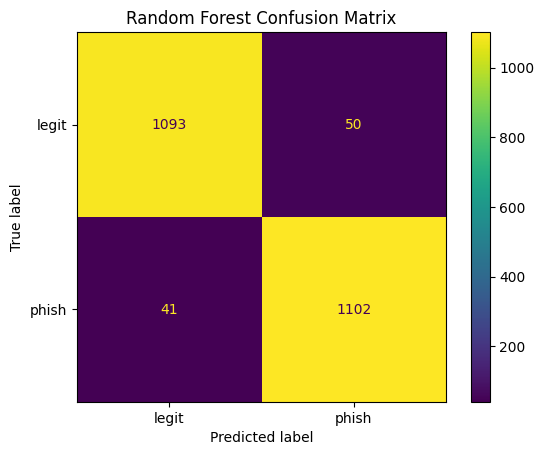

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tab_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_tab_scaled)
y_proba_rf = rf_model.predict_proba(X_test_tab_scaled)[:, 1]


# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1:", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))

#Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['legit','phish'])
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

#**SVM**

Accuracy: 0.9540682414698163
Precision: 0.9576719576719577
Recall: 0.9501312335958005
F1: 0.9538866930171278
ROC AUC: 0.9540682414698163


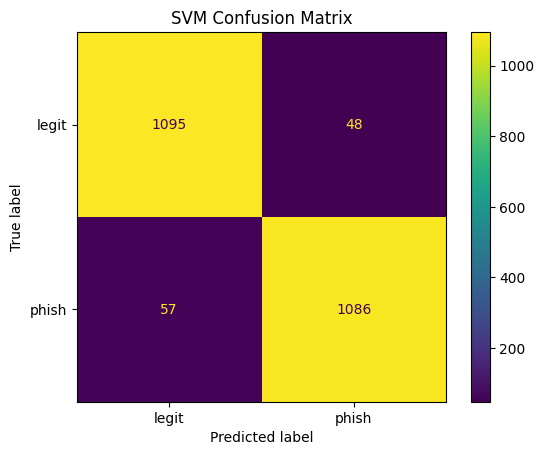

In [ ]:
# Enable probability estimates (needed for ROC AUC calculation)
svm_model = SVC(probability=True, random_state=42)

# Train the SVM model on the scaled tabular features
svm_model.fit(X_train_tab_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_tab_scaled)
y_proba_svm = svm_model.predict_proba(X_test_tab_scaled)[:, 1]

# Display results
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_svm, zero_division=0))
print("F1:", f1_score(y_test, y_pred_svm, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_pred_svm))

#Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['legit','phish'])
disp.plot()
plt.title("SVM Confusion Matrix")
plt.show()

#**XGBOOST**

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9671916010498688
Precision: 0.962738301559792
Recall: 0.9720034995625547
F1: 0.9673487157161516
ROC AUC: 0.9671916010498688


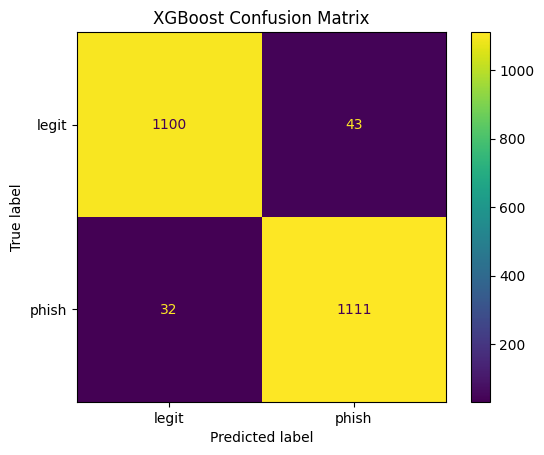

In [ ]:
xgb_baseline = XGBClassifier(use_label_encoder=False,
                             eval_metric='logloss',
                             n_estimators=200,
                             max_depth=6,
                             learning_rate=0.1,
                             random_state=42,
                             n_jobs=-1)

xgb_baseline.fit(X_train_tab_scaled, y_train)
preds_xgb = xgb_baseline.predict(X_test_tab_scaled)

#Display Results
print("Accuracy:", accuracy_score(y_test, preds_xgb))
print("Precision:", precision_score(y_test, preds_xgb, zero_division=0))
print("Recall:", recall_score(y_test, preds_xgb, zero_division=0))
print("F1:", f1_score(y_test, preds_xgb, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, preds_xgb))

#Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, preds_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['legit','phish'])
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

#**CNN**

In [ ]:
# Define the model
url_input = Input(shape=(MAX_LENGTH,), name='url_input')
emb_layer = Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_DIM,
                      input_length=MAX_LENGTH)(url_input)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(emb_layer)
pool_layer = GlobalMaxPooling1D()(conv_layer)
cnn_features = Dense(64, activation='relu', name='cnn_features')(pool_layer) # This is the layer we will extract
dropout = Dropout(0.3)(cnn_features)
output = Dense(1, activation='sigmoid')(dropout)

cnn_model = Model(inputs=url_input, outputs=output)
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

# Early stopping
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


--- Training 1D-CNN Feature Extractor ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ url_input (InputLayer)          │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 200, 64)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 196, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,209 (211.75 KB)

 Trainable params: 54,209 (211.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN
history = cnn_model.fit(
    X_train_url_padded, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1, # Use 10% of training data for validation
    callbacks=[es],
    verbose=2
)

Epoch 1/19
129/129 - 17s - 134ms/step - accuracy: 0.7608 - loss: 0.4999 - val_accuracy: 0.8459 - val_loss: 0.3521
Epoch 2/19
129/129 - 18s - 143ms/step - accuracy: 0.8675 - loss: 0.3151 - val_accuracy: 0.8984 - val_loss: 0.2649
Epoch 3/19
129/129 - 20s - 152ms/step - accuracy: 0.9081 - loss: 0.2324 - val_accuracy: 0.9027 - val_loss: 0.2214
Epoch 4/19
129/129 - 13s - 99ms/step - accuracy: 0.9324 - loss: 0.1796 - val_accuracy: 0.9268 - val_loss: 0.1983
Epoch 5/19
129/129 - 13s - 98ms/step - accuracy: 0.9501 - loss: 0.1401 - val_accuracy: 0.9158 - val_loss: 0.1951
Epoch 6/19
129/129 - 12s - 94ms/step - accuracy: 0.9639 - loss: 0.1072 - val_accuracy: 0.9180 - val_loss: 0.2094
Epoch 7/19
129/129 - 12s - 95ms/step - accuracy: 0.9765 - loss: 0.0761 - val_accuracy: 0.9049 - val_loss: 0.2531
Epoch 8/19
129/129 - 20s - 156ms/step - accuracy: 0.9844 - loss: 0.0566 - val_accuracy: 0.9268 - val_loss: 0.2012
Epoch 9/19
129/129 - 13s - 99ms/step - accuracy: 0.9898 - loss: 0.0380 - val_accuracy: 0.931

Making predictions on the test set...
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Predictions complete.

📊 Standalone 1D-CNN Performance Metrics:
Accuracy : 0.9291
Precision: 0.9306
Recall   : 0.9274
F1 Score : 0.9290
ROC AUC  : 0.9807

--- Plotting CNN Confusion Matrix ---


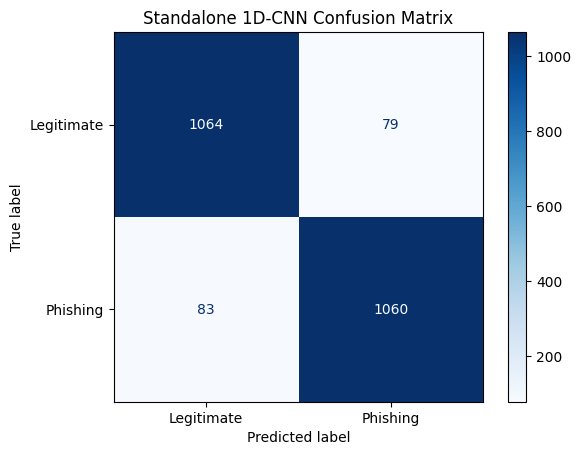

In [ ]:
print("Making predictions on the test set...")

#Get predicted probabilities from the CNN (values between 0 and 1)
#We .ravel() flattens the output from shape (N, 1) to (N,)
y_prob_cnn = cnn_model.predict(X_test_url_padded).ravel()

# Convert probabilities into final classes labels (0 or 1) using 0.5 threshold
y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

print("Predictions complete.")

# --- Evaluation Metrics ---

# Compare predicted labels (y_pred_cnn) to true labels (y_test)
print("\n📊 Standalone 1D-CNN Performance Metrics:")

# Accuracy
print(f"Accuracy : {accuracy_score(y_test, y_pred_cnn):.4f}")

# Precision
print(f"Precision: {precision_score(y_test, y_pred_cnn, zero_division=0):.4f}")

# Recall
print(f"Recall   : {recall_score(y_test, y_pred_cnn, zero_division=0):.4f}")

# F1 Score
print(f"F1 Score : {f1_score(y_test, y_pred_cnn, zero_division=0):.4f}")

# ROC AUC Score
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob_cnn):.4f}")


# Confusion Matrix for CNN
print("\n--- Plotting CNN Confusion Matrix ---")

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(cm_cnn, display_labels=['Legitimate', 'Phishing'])
disp.plot(cmap='Blues')
plt.title("Standalone 1D-CNN Confusion Matrix")
plt.show()

#**HYBRID MODEL**

Getting predictions from XGBoost (xgb_baseline)...
Getting predictions from CNN (cnn_model)...
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

📊 Weighted Averaging (80/20) Performance:
Accuracy : 0.9703
Precision: 0.9670
Recall   : 0.9738
F1 Score : 0.9704
ROC AUC  : 0.9948


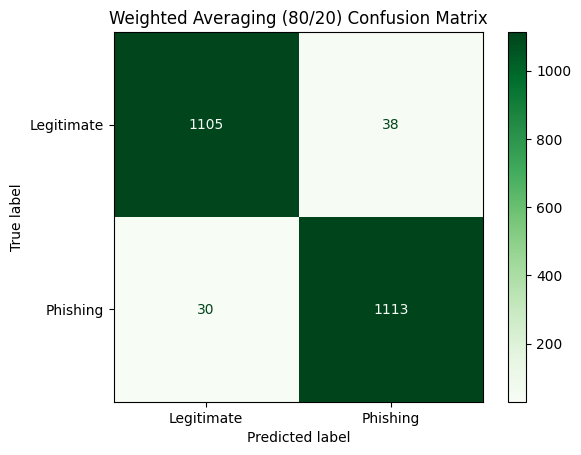

In [ ]:
# 'xgb_baseline' is the trained standalone XGBoost model
print("Getting predictions from XGBoost (xgb_baseline)...")
y_proba_xgb = xgb_baseline.predict_proba(X_test_tab_scaled)[:, 1]


# 'cnn_model' is the trained 1D-CNN model
print("Getting predictions from CNN (cnn_model)...")
y_proba_cnn = cnn_model.predict(X_test_url_padded).ravel()

# --- Weighted Ensemble (80% XGBoost, 20% CNN) ---
# XGBoost receives a higher weight based on its superior standalone performance
y_proba_hybrid_avg = (y_proba_xgb * 0.8) + (y_proba_cnn * 0.2)

# Convert combined probabilities into final class labels using a 0.5 threshold
y_pred_hybrid_avg = (y_proba_hybrid_avg >= 0.5).astype(int)

# Display Evaluation Metrics for Hybrid Model
print("\n📊 Weighted Averaging (80/20) Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_hybrid_avg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_hybrid_avg, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_hybrid_avg, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_hybrid_avg, zero_division=0):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_proba_hybrid_avg):.4f}")

#Confusion Matrix for Hybrid Model
cm_hybrid_avg = confusion_matrix(y_test, y_pred_hybrid_avg)
disp = ConfusionMatrixDisplay(cm_hybrid_avg, display_labels=['Legitimate', 'Phishing'])
disp.plot(cmap='Greens')
plt.title("Weighted Averaging (80/20) Confusion Matrix")
plt.show()

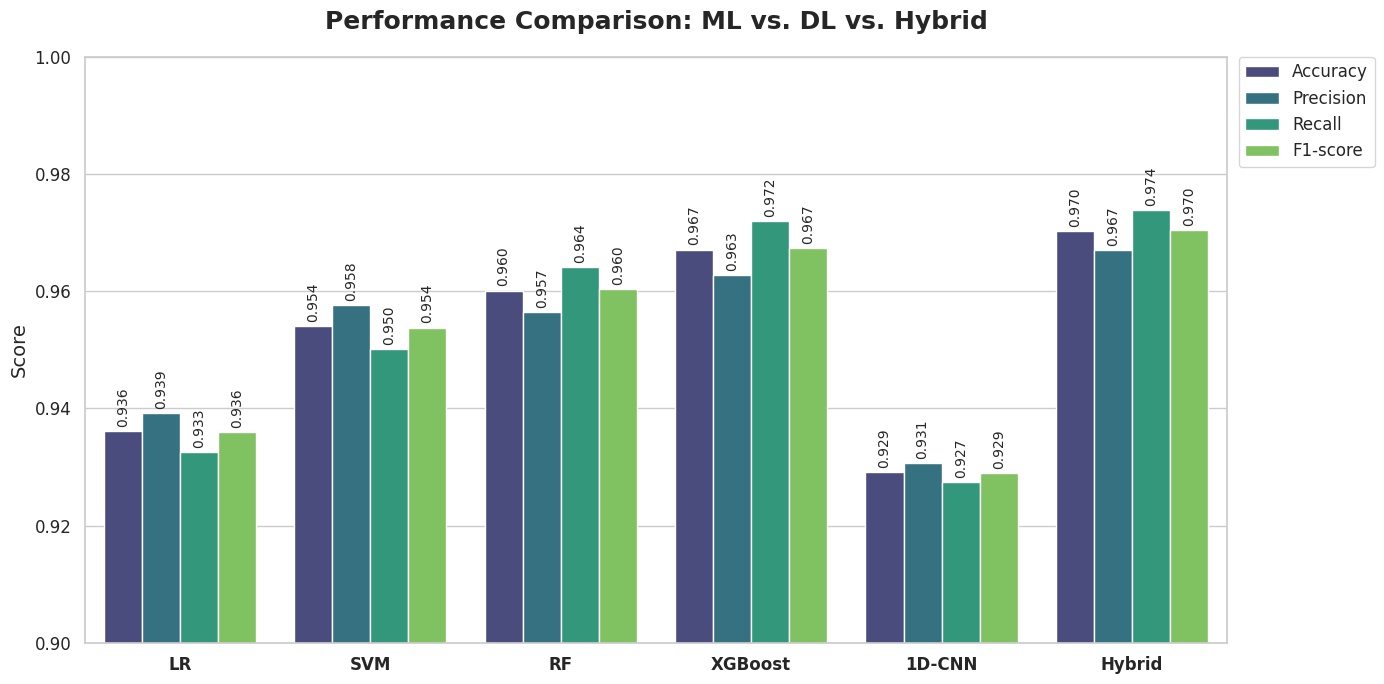

In [ ]:
# Create a dictionary of model performance scores
results = {
    "Model": ["LR", "SVM", "RF", "XGBoost", "1D-CNN", "Hybrid"],
    "Accuracy":  [0.9361, 0.9540, 0.9601, 0.9671, 0.9291, 0.9703],
    "Precision": [0.9392, 0.9576, 0.9565, 0.9627, 0.9306, 0.9670],
    "Recall":    [0.9326, 0.9501, 0.9641, 0.9720, 0.9274, 0.9738],
    "F1-score":  [0.9359, 0.9538, 0.9603, 0.9673, 0.9290, 0.9704]
}

# Convert results into a DataFrame
df = pd.DataFrame(results)

# Reshape DataFrame for grouped bar plotting (Model × Metric)
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# --- Visualization Setup ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot grouped bar chart of performance metrics
chart = sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted, palette="viridis")

plt.ylim(0.90, 1.0)

# Add numerical score labels on each bar
for container in chart.containers:
    chart.bar_label(container, fmt='%.3f', padding=3, fontsize=10, rotation=90)

# Titles and axis labels
plt.title("Performance Comparison: ML vs. DL vs. Hybrid", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)


plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=12)


plt.tight_layout()
plt.savefig("Poster_Graph_AllModels.png", dpi=300)
plt.show()